## Part 1.8 - Data augmentation
#### *Pol Roca Llaberia*

With this experiemnt we will carry out our last attempt to try to improve the model perfomance on scarce data. In this case, we will tackle the problem with data directly by applying some data augmentation techniques. This strategy, though, for sure cannot be applied blindly.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np 

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
N = 300

In [ ]:
X_train = X_train[:N]
y_train = y_train[:N]
X_test = X_test[:2500]
y_test = y_test[:2500]

# Make sure images have shape (28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [ ]:
print(X_train.shape)
print(X_test.shape)
np.unique(y_test, return_counts=True)

(300, 28, 28, 1)
(2500, 28, 28, 1)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([219, 287, 276, 254, 275, 221, 225, 257, 242, 244]))

Define data generators that will augment the dataset on the go

In [ ]:
generators = [
    ImageDataGenerator(),

    ImageDataGenerator(rotation_range=30),

    ImageDataGenerator(width_shift_range=0.2),

    ImageDataGenerator(height_shift_range=0.2),

    ImageDataGenerator(zoom_range=0.15),

    ImageDataGenerator(shear_range=0.15),

    ImageDataGenerator(horizontal_flip=True),

    ImageDataGenerator(vertical_flip=True),
]

In [ ]:
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(20, (5, 5), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(num_classes))
    return model

In [ ]:
model = build_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2880)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                28810     
Total params: 29,330
Trainable params: 29,330
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

We save the model weights so that each experiment starts from the same exact point with the same randomness

In [ ]:
model.save_weights('initial.h5')

In [ ]:
histories = []
metrics = []
epochs = 70

for img_gen in generators:
    model.load_weights('initial.h5')
    data_train = img_gen.flow(X_train, y_train, batch_size=32)
    history = model.fit(data_train, 
                        epochs=epochs, 
                        validation_data=(X_test, y_test), 
                        verbose=1)
    histories.append(history.history)
    metrics.append(model.evaluate(X_test,  y_test))

Epoch 1/70
10/10 [==============================] - 1s 32ms/step - loss: 139.4458 - accuracy: 0.0750 - val_loss: 2.3079 - val_accuracy: 0.0884
Epoch 2/70
10/10 [==============================] - 0s 19ms/step - loss: 2.2926 - accuracy: 0.1132 - val_loss: 2.3139 - val_accuracy: 0.1220
Epoch 3/70
10/10 [==============================] - 0s 20ms/step - loss: 2.2607 - accuracy: 0.1511 - val_loss: 2.2630 - val_accuracy: 0.1856
Epoch 4/70
10/10 [==============================] - 0s 21ms/step - loss: 2.2098 - accuracy: 0.2419 - val_loss: 2.2105 - val_accuracy: 0.2016
Epoch 5/70
10/10 [==============================] - 0s 19ms/step - loss: 2.0261 - accuracy: 0.2683 - val_loss: 2.3187 - val_accuracy: 0.3040
Epoch 6/70
10/10 [==============================] - 0s 19ms/step - loss: 1.9795 - accuracy: 0.3197 - val_loss: 2.3380 - val_accuracy: 0.1428
Epoch 7/70
10/10 [==============================] - 0s 21ms/step - loss: 2.1415 - accuracy: 0.2735 - val_loss: 2.3273 - val_accuracy: 0.1076
Epoch 8/70


In [ ]:
for loss, acc in np.round(metrics, 2):
    print(f'loss: {loss:.2f} accuracy: {acc:.2f}')

loss: 3.55 accuracy: 0.60
loss: 2.34 accuracy: 0.71
loss: 2.25 accuracy: 0.69
loss: 2.51 accuracy: 0.47
loss: 3.39 accuracy: 0.74
loss: 2.81 accuracy: 0.65
loss: 4.09 accuracy: 0.56
loss: 3.00 accuracy: 0.61


In [ ]:
def plot_curves(history, axes, title=''):
    # plot accuracy
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    epochs = range(1, len(acc)+1)

    ax = axes[0]
    ax.plot(epochs, acc, 'b', label='Training Acc')
    ax.plot(epochs, val_acc, 'r', label='Validation Acc')
    ax.set_title('Accuracy curves | ' + title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.grid(alpha=0.4)
    ax.legend()

    # plot validation loss
    loss = history['loss']
    val_loss = history['val_loss']

    ax = axes[1]
    ax.plot(epochs, loss, 'b', label='Training loss')
    ax.plot(epochs, val_loss, 'r', label='Validation loss')
    ax.set_title('Loss curves | ' + title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.grid(alpha=0.4)
    ax.legend()

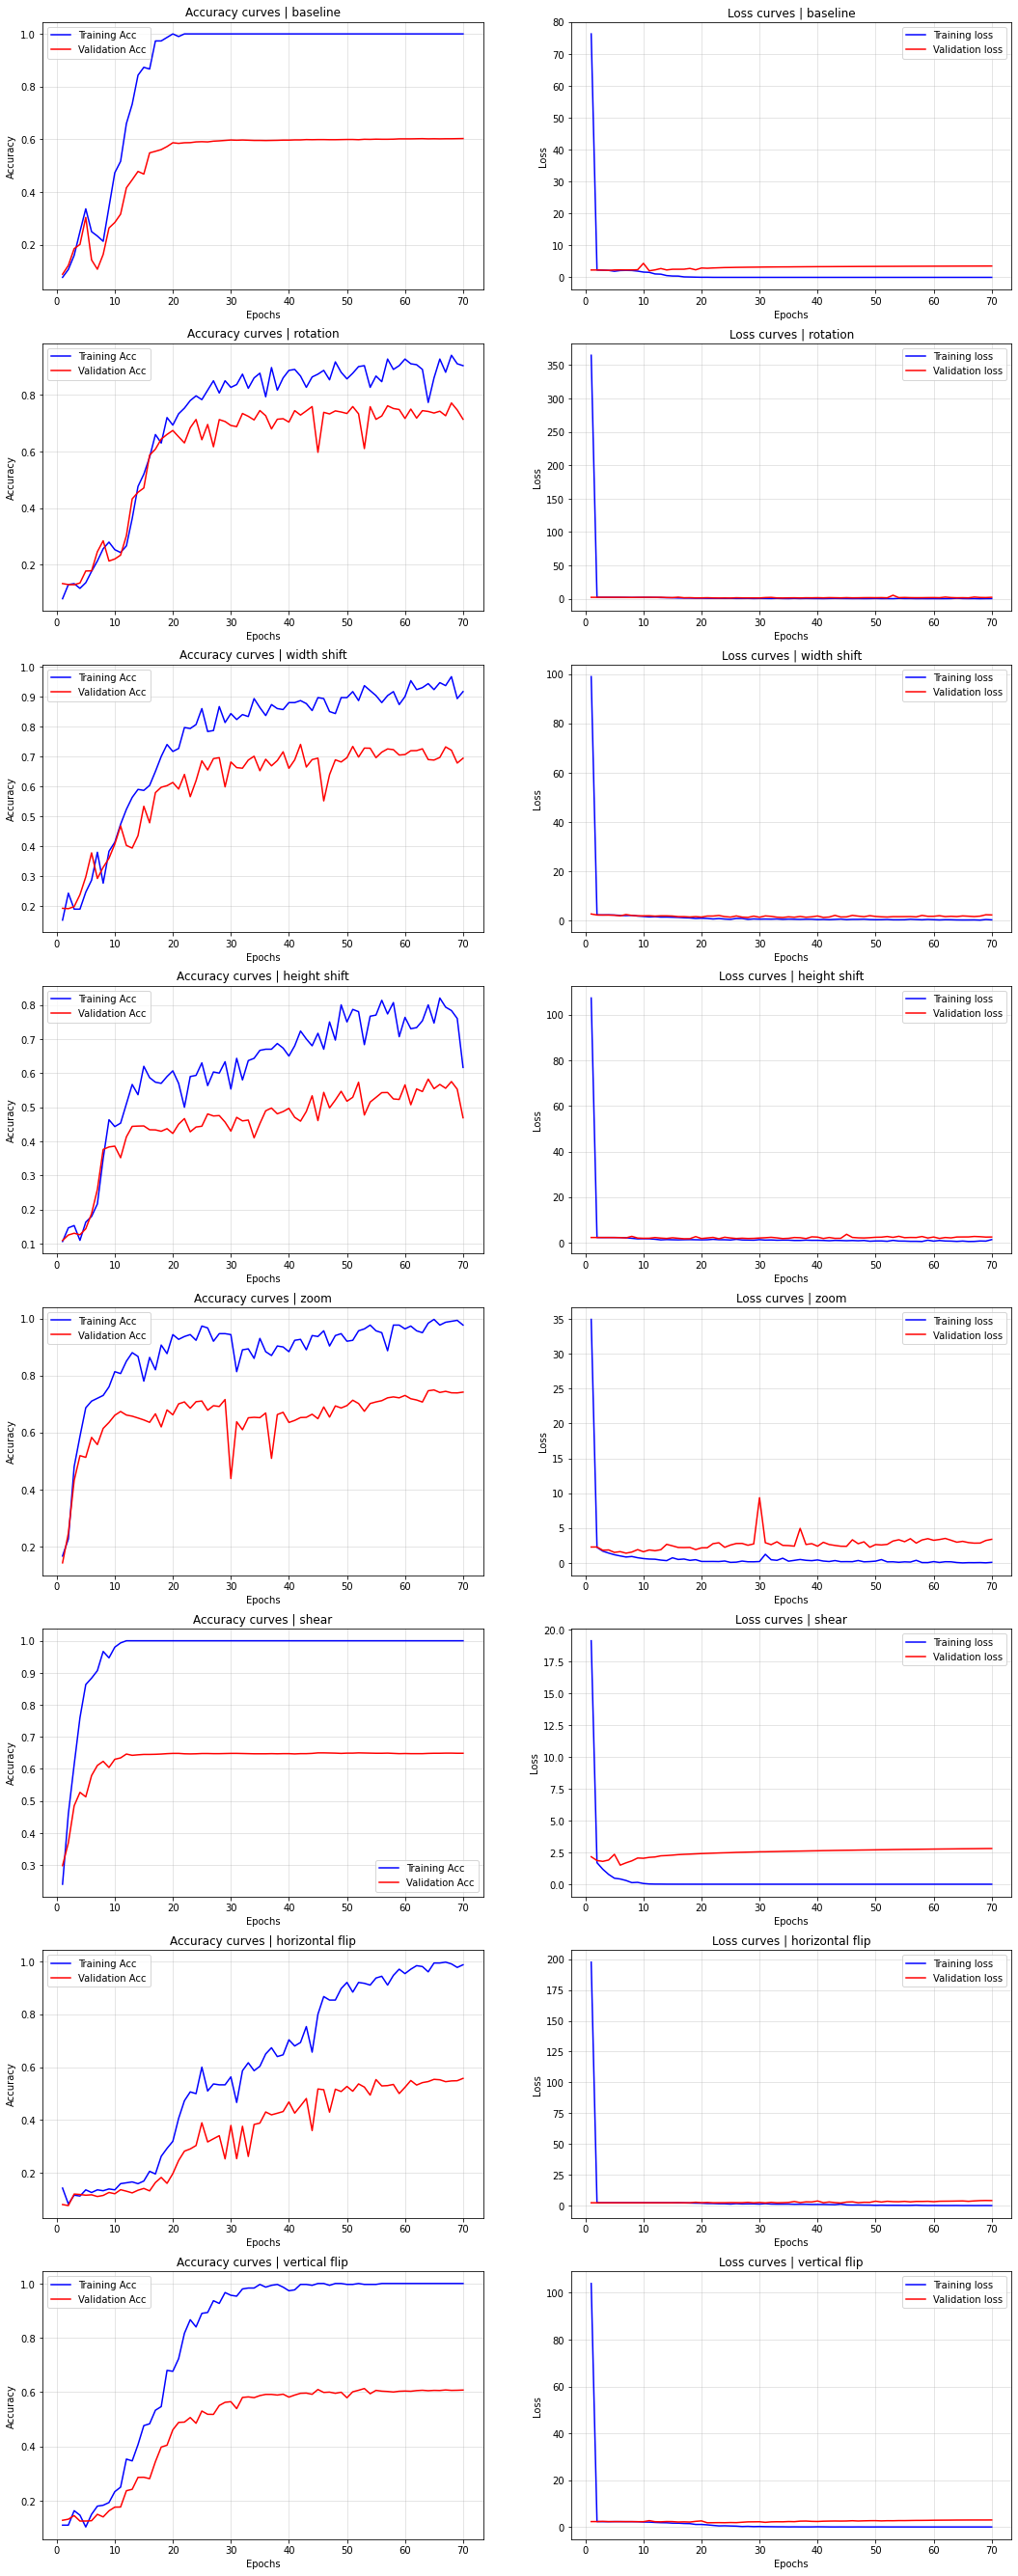

In [ ]:
fig, axes = plt.subplots(len(histories), 2, figsize=(18, 6*len(histories)))

titles = [
    'baseline',
    'rotation',
    'width shift',
    'height shift',
    'zoom',
    'shear',
    'horizontal flip',
    'vertical flip'
]

for i, history in enumerate(histories):
    plot_curves(history, axes[i], titles[i])

plt.show()

### Observations

To start with, we can see two improvements: final accuracy and validation loss are better than the baseline, in general. 

Regarding the loss curves, when taking scale into account, we can observe the same shape in every plot.

Let's see more into detail each form of data augmentation and try to deduce if the improvements are founded by some logic or results are totally random:
 - **Baseline (0.60)**
 - **Rotation (0.71)**: One of the best results. In this case, it makes sense to obtain a better performance because handwritten digits normally already appear with some slight rotations due to them being written by humans. For instance, some unrotated instances may have shapes similar to other instances of the same digit that, when rotated, are very alike.
 - **Width shift (0.69)**: Very good result as well. Here, this new data can make the model more robust to small translations that can appear due to the variance in the data. However...
 - **Height shift (0.47)**: The accuracy should be higher since training ended on a negative peak or valley, although it would still be lower than the baseline. This is a rather strange behaviour, since with width shifts we obtained very good resuls on the contrary of height shifts. One possible explanation to that could be that the dataset is already centered vertically, so that height shifts do not bring useful cases to learn for the model.
 - **Zoom (0.74)**: By far, the best improvement. Note that only small zooms are applied (up to 15%) which is also the norm for all other augmentation techniques, so as not to distort too much the data. In any case, the ranges of these parameters are always in a tradeoff between increasing diversity in data (good) and increasing intra-class variability by too much (bad). Seemingly, zooming is often very suitable when trying to increase the diversity of an image dataset, and it makes sense by itself.
 - **Shear (0.65)**: Also provides good results. Again, only small shears were applied. This is maybe the strategy that modifies the images more intuitively, because shears are a common characteristic that differentiate writings from one person to another, and adding more of that distortion helps to enchance the dataset with more diversity.
 - **Vertical flip (0.56) & Horizontal flip (0.61)**: Arguably not significant enough results. On the one hand, vertical flips add more variations of some digits such as 0's, 1's, 3's and 8's, but add noise when other digits are flipped. On the other hand, hortizontal flips make sense when 0's, 1's and 8's are flipped, but not for the other digits. In my opinion, flips are very dependent on the nature of the dataset, and in this case, they have to be restricted to some specific labels. Therefore, I think the results in this experiment are just random variations, with no significance.

---